# Первая схема "предиктор-корректор" для уравнения:
\begin{cases}
\dfrac{\partial u}{\partial t} = \Delta u + e^t\sin\dfrac{3\pi x}{2}\sin\pi z ,\quad x\in (0,1),\ y\in (0,1),\ z\in (0,1),\ t \in (0,1] \\
u\rvert_{t=0}=\sin\dfrac{\pi x}{2}\cos 2\pi y\sin\pi z, \\
u\rvert_{x=0}=0, \quad \dfrac{\partial u}{\partial x}\bigg\rvert_{x=1}=0, \\
\dfrac{\partial u}{\partial y}\bigg\rvert_{y=0} = \dfrac{\partial u}{\partial y}\bigg\rvert_{y=1}=0, \\
u\rvert_{z=0}=u\rvert_{z=1}=0.
\end{cases}

In [1]:
# аналитическое решение
u(x,y,z,t) = exp(-pi^2*(1/4+5)*t)*sin(pi/2*x)*cos(2pi*y)*sin(pi*z) +
                  1/(1+13/4*pi^2)*(exp(t)-exp(-13/4*pi^2*t))*sin(3pi/2*x)*sin(pi*z)

u (generic function with 1 method)

In [2]:
lx, ly, lz = 1, 1, 1
r = 4
N, M, K = 10*r, 10*r, 10*r

hx, hy, hz = lx/(N-1/2), ly/(M-1), lz/K

x =     0:hx:lx+hx/2
y = -hy/2:hy:ly+hy/2
z =     0:hz:lz

T = 0.15
J = 30*r          # число временных интервалов
tau = T/J       # шаг по времени
J += 1    # число временных слоев

t = 0:tau:T

0.0:0.00125:0.15

In [3]:
function thomas_alg(A, B, C, F)
    N = length(A)
    K = zeros(Float64, N+1)
    E = zeros(Float64, N+1)

    for i = 1:N
        K[i+1] = -C[i]/(B[i] + A[i]*K[i])
        E[i+1] = (F[i] - A[i]*E[i])/(B[i] + A[i]*K[i])
    end

    x = zeros(Float64, N+1)
    for i = N:-1:1
        x[i] = K[i+1]*x[i+1] + E[i+1]
    end

    return x[1:N]
end

thomas_alg (generic function with 1 method)

In [4]:
U = Array{Float64,4}(undef,J,N+1,M+1,K+1)

# правая часть
f(x,y,z,t) = exp(t)*sin(3pi/2*x)*sin(pi*z)

# начальное условие
U[1,:,:,:] = [sin(pi/2*x[n])*cos(2pi*y[m])*sin(pi*z[k])  for n=1:N+1, m=1:M+1, k=1:K+1]

for j = 1:J-1
    y1 = zeros(N+1,M+1,K+1)
    y2 = zeros(N+1,M+1,K+1)
    y3 = zeros(N+1,M+1,K+1)
    
    for m = 2:M, k = 2:K
        A = 1/hx^2 * ones(N+1)
        C = copy(A)
        B = -(A + C .+ 2/tau)
        F = -( (f.(x,y[m],z[k],t[j]) + f.(x,y[m],z[k],t[j+1]))/2 +
               (2/tau-2/hy^2-2/hz^2)*U[j,:,m,k] +
                1/hy^2*(U[j,:,m-1,k] + U[j,:,m+1,k]) +
                1/hz^2*(U[j,:,m,k-1] + U[j,:,m,k+1]) )
        
        A[1] = 0;    B[1] = 1;     C[1] = 0;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;  F[end] = 0
        
        y1[:,m,k] = thomas_alg(A,B,C,F)
    end
    y1[:,1,:]   = y1[:,2,:]
    y1[:,end,:] = y1[:,end-1,:]
    y1[:,:,1]  .= 0
    y1[:,:,end].= 0
    
    
    for n = 2:N, k = 2:K
        A = 1/hy^2 * ones(M+1)
        C = copy(A)
        B = -(A + C .+ 2/tau)
        F = zeros(M+1)
        F[2:end-1] = 1/hy^2*(U[j,n,1:end-2,k] - 2*U[j,n,2:end-1,k] + U[j,n,3:end,k]) -
                     2/tau*y1[n,2:end-1,k]
        
        A[1] = 0;    B[1] = 1;     C[1] = -1;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;  F[end] = 0
        
        y2[n,:,k] = thomas_alg(A,B,C,F)
    end
    y2[1,:,:]  .= 0
    y2[end,:,:] = y2[end-1,:,:]
    y2[:,:,1]  .= 0
    y2[:,:,end].= 0
    
    
    for n = 2:N, m = 2:M
        A = 1/hz^2 * ones(K+1)
        C = copy(A)
        B = -(A + C .+ 2/tau)
        F = zeros(M+1)
        F[2:end-1] = 1/hz^2*(U[j,n,m,1:end-2] - 2*U[j,n,m,2:end-1] + U[j,n,m,3:end]) -
                     2/tau*y2[n,m,2:end-1]
        
        A[1] = 0;    B[1] = 1;     C[1] = 0;    F[1] = 0
        A[end] = 0;  B[end] = 1;   C[end] = 0;  F[end] = 0
        
        y3[n,m,:] = thomas_alg(A,B,C,F)
    end
    y3[1,:,:]  .= 0
    y3[end,:,:] = y3[end-1,:,:]
    y3[:,1,:]   = y3[:,2,:]
    y3[:,end,:] = y3[:,end-1,:]
    
    U[j+1,2:N,2:M,2:K] = U[j,2:N,2:M,2:K] + 
                         tau * (1/hx^2*(y1[1:N-1,2:M,2:K] - 2*y1[2:N,2:M,2:K] + y1[3:N+1,2:M,2:K]) +
                                1/hy^2*(y2[2:N,1:M-1,2:K] - 2*y2[2:N,2:M,2:K] + y2[2:N,3:M+1,2:K]) +
                                1/hz^2*(y3[2:N,2:M,1:K-1] - 2*y3[2:N,2:M,2:K] + y3[2:N,2:M,3:K+1]) +
                                [(f(x[n],y[m],z[k],t[j])+f(x[n],y[m],z[k],t[j+1]))/2 for n=2:N,m=2:M,k=2:K])
    
    U[j+1,1,:,:]  .= 0
    U[j+1,end,:,:] = U[j+1,end-1,:,:]
    U[j+1,:,1,:]   = U[j+1,:,2,:]
    U[j+1,:,end,:] = U[j+1,:,end-1,:]
    U[j+1,:,:,1]  .= 0
    U[j+1,:,:,end].= 0
end

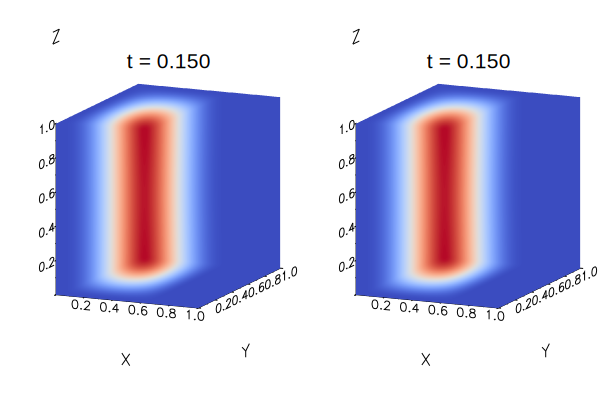

In [5]:
using Printf, Plots

j = J
num = plot(U[j,:,:,:], xlabel="X", ylabel="Y", zlabel="Z")
exact = plot([u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1], xlabel="X", ylabel="Y", zlabel="Z")
Title = "t = " * @sprintf("%.3f", t[j])
plot(num, exact, xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)

In [6]:
using Printf, ProgressMeter
pr = Progress(J, 1)

anim = @animate for j = 1:J
    num = plot(U[j,:,:,:], xlabel="X", ylabel="Y", zlabel="Z")
    exact = plot([u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1], xlabel="X", ylabel="Y", zlabel="Z")
    Title = "t = " * @sprintf("%.3f", t[j])
    plot(num, exact, xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)
    next!(pr) # update progress bar
end
gif(anim, "predictor.gif") 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
┌ Info: Saved animation to 
│   fn = /home/merlin/msu/кафмат 8 сем/predictor.gif
└ @ Plots /home/merlin/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/home/merlin/msu/кафмат 8 сем/predictor.gif")

In [7]:
using Printf, ProgressMeter
pr = Progress(J, 1)

anim = @animate for j = 1:J
    error = abs.(U[j,:,:,:] - [u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1])
    Title = "t = " * @sprintf("%.3f", t[j]) * ", max =" * @sprintf("%.2E", maximum(error))
    plot(error, xlabel="X", ylabel="Y", zlabel="Z", xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)
    next!(pr) # update progress bar
end
gif(anim, "predictor_error.gif") 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
┌ Info: Saved animation to 
│   fn = /home/merlin/msu/кафмат 8 сем/predictor_error.gif
└ @ Plots /home/merlin/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/home/merlin/msu/кафмат 8 сем/predictor_error.gif")

## Локально-одномерная схема

In [8]:
U = Array{Float64,4}(undef,J,N+1,M+1,K+1)

# правая часть
f(x,y,z,t) = exp(t)*sin(3pi/2*x)*sin(pi*z)

# начальное условие
U[1,:,:,:] = [sin(pi/2*x[n])*cos(2pi*y[m])*sin(pi*z[k])  for n=1:N+1, m=1:M+1, k=1:K+1]

for j = 1:J-1
    y1 = zeros(N+1,M+1,K+1)
    
    for m = 2:M, k = 2:K
        A = 1/hx^2 * ones(N+1)
        C = copy(A)
        B = -(2*A .+ 1/tau)
        F = -( 1/tau*U[j,:,m,k] + 1/3*f.(x,y[m],z[k],t[j]+tau/3) )
        
        A[1] = 0;    B[1] = 1;     C[1] = 0;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;  F[end] = 0
        
        y1[:,m,k] = thomas_alg(A,B,C,F)
    end
    y1[:,1,:]   = y1[:,2,:]
    y1[:,end,:] = y1[:,end-1,:]
    y1[:,:,1]  .= 0
    y1[:,:,end].= 0
    
    y2 = zeros(N+1,M+1,K+1)
    for n = 2:N, k = 2:K
        A = 1/hy^2 * ones(M+1)
        C = copy(A)
        B = -(2*A .+ 1/tau)
        F = -( 1/tau*y1[n,:,k] + 1/3*f.(x[n],y,z[k],t[j]+2/3*tau) )
        
        A[1] = 0;    B[1] = 1;     C[1] = -1;    F[1] = 0
        A[end] = 1;  B[end] = -1;  C[end] = 0;  F[end] = 0
        
        y2[n,:,k] = thomas_alg(A,B,C,F)
    end
    y2[1,:,:]  .= 0
    y2[end,:,:] = y2[end-1,:,:]
    y2[:,:,1]  .= 0
    y2[:,:,end].= 0
    
    y3 = zeros(N+1,M+1,K+1)
    for n = 2:N, m = 2:M
        A = 1/hz^2 * ones(K+1)
        C = copy(A)
        B = -(2*A .+ 1/tau)
        F = -( 1/tau*y2[n,m,:] + 1/3*f.(x[n],y[m],z,t[j+1]) )
        
        A[1] = 0;    B[1] = 1;     C[1] = 0;    F[1] = 0
        A[end] = 0;  B[end] = 1;   C[end] = 0;  F[end] = 0
        
        y3[n,m,:] = thomas_alg(A,B,C,F)
    end
    y3[1,:,:]  .= 0
    y3[end,:,:] = y3[end-1,:,:]
    y3[:,1,:]   = y3[:,2,:]
    y3[:,end,:] = y3[:,end-1,:]
    
    U[j+1,:,:,:] = y3
end

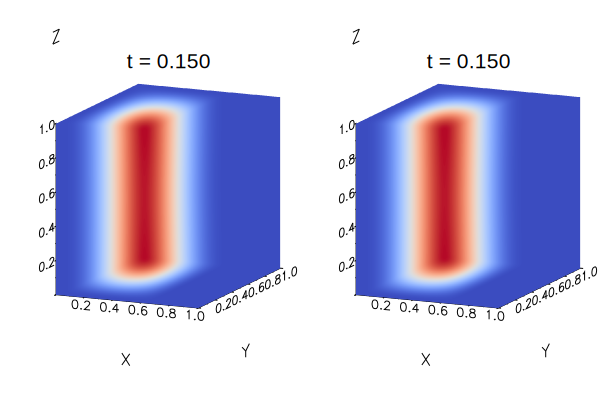

In [9]:
using Printf, Plots

j = J
num = plot(U[j,:,:,:], xlabel="X", ylabel="Y", zlabel="Z")
exact = plot([u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1], xlabel="X", ylabel="Y", zlabel="Z")
Title = "t = " * @sprintf("%.3f", t[j])
plot(num, exact, xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)

In [10]:
using Printf, ProgressMeter
pr = Progress(J, 1)

anim = @animate for j = 1:J
    num = plot(U[j,:,:,:], xlabel="X", ylabel="Y", zlabel="Z")
    exact = plot([u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1], xlabel="X", ylabel="Y", zlabel="Z")
    Title = "t = " * @sprintf("%.3f", t[j])
    plot(num, exact, xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)
    next!(pr) # update progress bar
end
gif(anim, "summar.gif") 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
┌ Info: Saved animation to 
│   fn = /home/merlin/msu/кафмат 8 сем/summar.gif
└ @ Plots /home/merlin/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/home/merlin/msu/кафмат 8 сем/summar.gif")

In [11]:
using Printf, ProgressMeter
pr = Progress(J, 1)

anim = @animate for j = 1:J
    error = abs.(U[j,:,:,:] - [u(x[n],y[m],z[k],t[j]) for n=1:N+1,m=1:M+1,k=1:K+1])
    Title = "t = " * @sprintf("%.3f", t[j]) * ", max =" * @sprintf("%.2E", maximum(error))
    plot(error, xlabel="X", ylabel="Y", zlabel="Z", xlim=(0,1), ylim=(0,1), zlim=(0,1), title=Title)
    next!(pr) # update progress bar
end
gif(anim, "summar_error.gif") 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
┌ Info: Saved animation to 
│   fn = /home/merlin/msu/кафмат 8 сем/summar_error.gif
└ @ Plots /home/merlin/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/home/merlin/msu/кафмат 8 сем/summar_error.gif")